In [74]:
# importanto as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import date, time, datetime, timedelta
from prophet import Prophet

#from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
#drive.mount('drive')

In [ ]:
df = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa.csv', sep=',', parse_dates=[0], index_col="Data",dayfirst=True)
df2 = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa (4).csv', sep=',', parse_dates=[0], index_col="Data",dayfirst=True)

In [ ]:
ibovespa_diario = pd.concat([df, df2])

In [2]:
ibovespa_diario = pd.read_csv(r'dados_ibovespa_dez00-ago23.csv', sep=',', parse_dates=[0], index_col="Data",dayfirst=True)

In [3]:
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,"3,67M","-0,76%"
2019-12-27,116.534,117.205,117.803,115.995,"3,91M","-0,57%"
2019-12-26,117.203,115.864,117.220,115.673,"3,79M","1,16%"
2019-12-23,115.863,115.119,115.863,114.964,"4,00M","0,64%"
2019-12-20,115.121,115.133,115.171,114.526,"6,89M","-0,01%"


In [4]:
ibovespa_diario = ibovespa_diario.sort_index()

In [5]:
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2000-12-27,15.186,14.805,15.223,14.805,"239,98M","2,65%"
2000-12-28,15.259,15.188,15.269,15.132,"324,26M","0,48%"
2001-01-02,15.425,15.242,15.621,15.174,"230,63M","1,09%"
2001-01-03,16.599,15.425,16.599,15.251,"381,20M","7,61%"
2001-01-04,16.675,16.597,16.933,16.587,"331,23M","0,46%"


In [ ]:
#ibovespa_diario.loc[ibovespa_diario.index.year > 2019].head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2020-01-02,118.573,115.652,118.573,115.649,"5,16M","2,53%"
2020-01-03,117.707,118.564,118.792,117.341,"6,83M","-0,73%"
2020-01-06,116.878,117.707,117.707,116.269,"6,57M","-0,70%"
2020-01-07,116.662,116.872,117.076,115.965,"4,85M","-0,18%"
2020-01-08,116.247,116.667,117.335,115.693,"5,91M","-0,36%"


In [ ]:
#ibovespa_diario = ibovespa_diario.loc[ibovespa_diario.index.year > 2020]

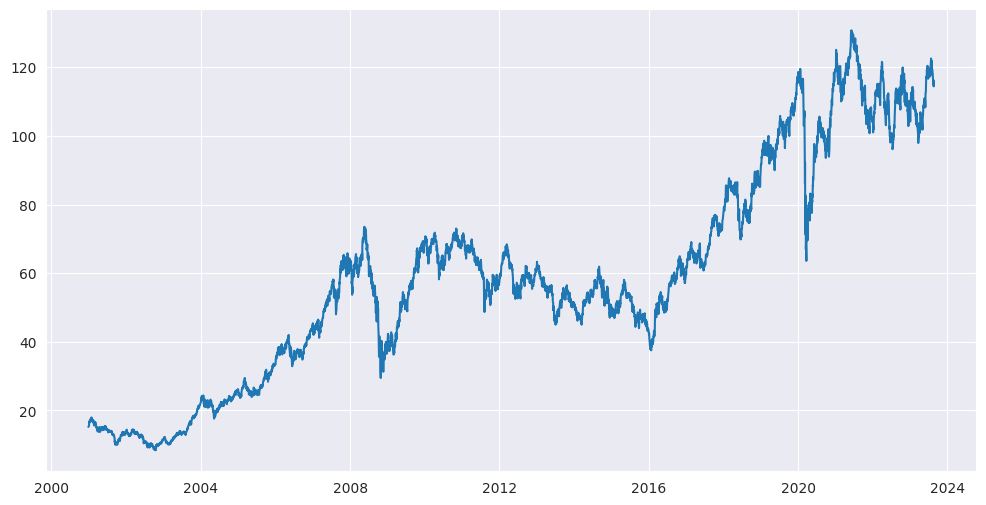

In [7]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.show()

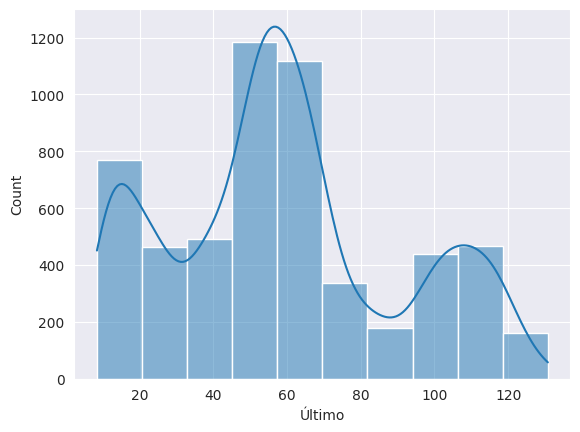

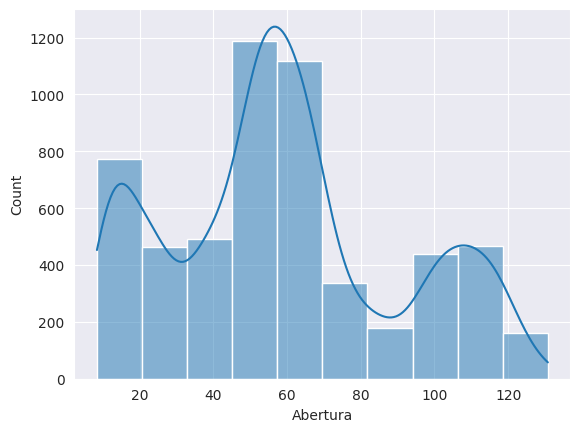

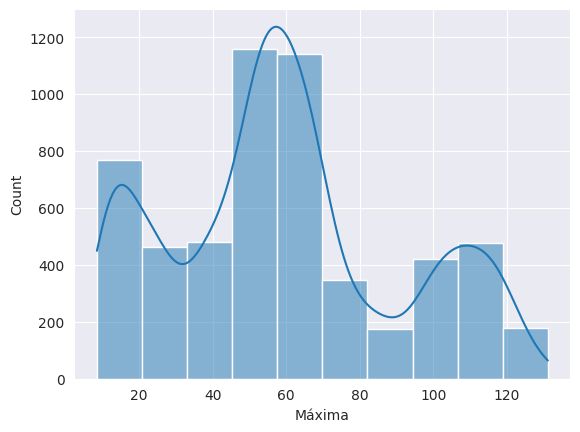

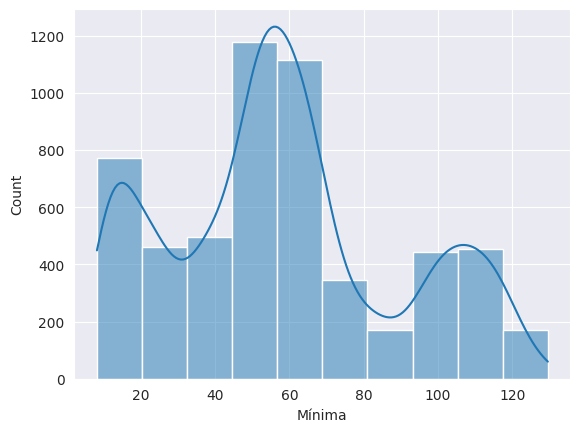

In [8]:
colunas_numericas_preco = ["Último", "Abertura", "Máxima", "Mínima"]
for column in colunas_numericas_preco:
    plt.figure()
    plot = ibovespa_diario[column]
    sns.histplot(plot, bins=10, kde=True)
    plt.show()

In [9]:
ibovespa_diario.shape

(5611, 6)

In [ ]:
from scipy.stats import norm, shapiro
my_data = ibovespa_diario['Último']
shapiro(my_data)

ShapiroResult(statistic=0.9889400601387024, pvalue=8.471467299386859e-05)

In [ ]:
shapiro(my_data).statistic

0.9889400601387024

In [ ]:
shapiro(my_data).pvalue

8.471467299386859e-05

In [75]:
# importação de bibliotecas para modelo e análise de series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas
import plotly.graph_objs as go
#import pandas_ta as ta
import math

In [7]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

Após a verificação dos dados apresentados na base, iniciamos o procedimento de decomposição da série temporal com isso conseguimos entender como está se dando as variações

In [ ]:
dados_decompose = ibovespa_diario[['Último']]
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

In [13]:
resultados = seasonal_decompose(dados_decompose, period=5, model='multiplicative')

Na decomposição dos dados de fechamento, podemos observar o tamanho que houveram alguns fatores que causaram um ruído dentro da base. No ano de 2008 onde a bolha de ímoveis americana estoura houveram respingos na nossa bolsa. E em 2020 chegada da covid-19 no Brasil

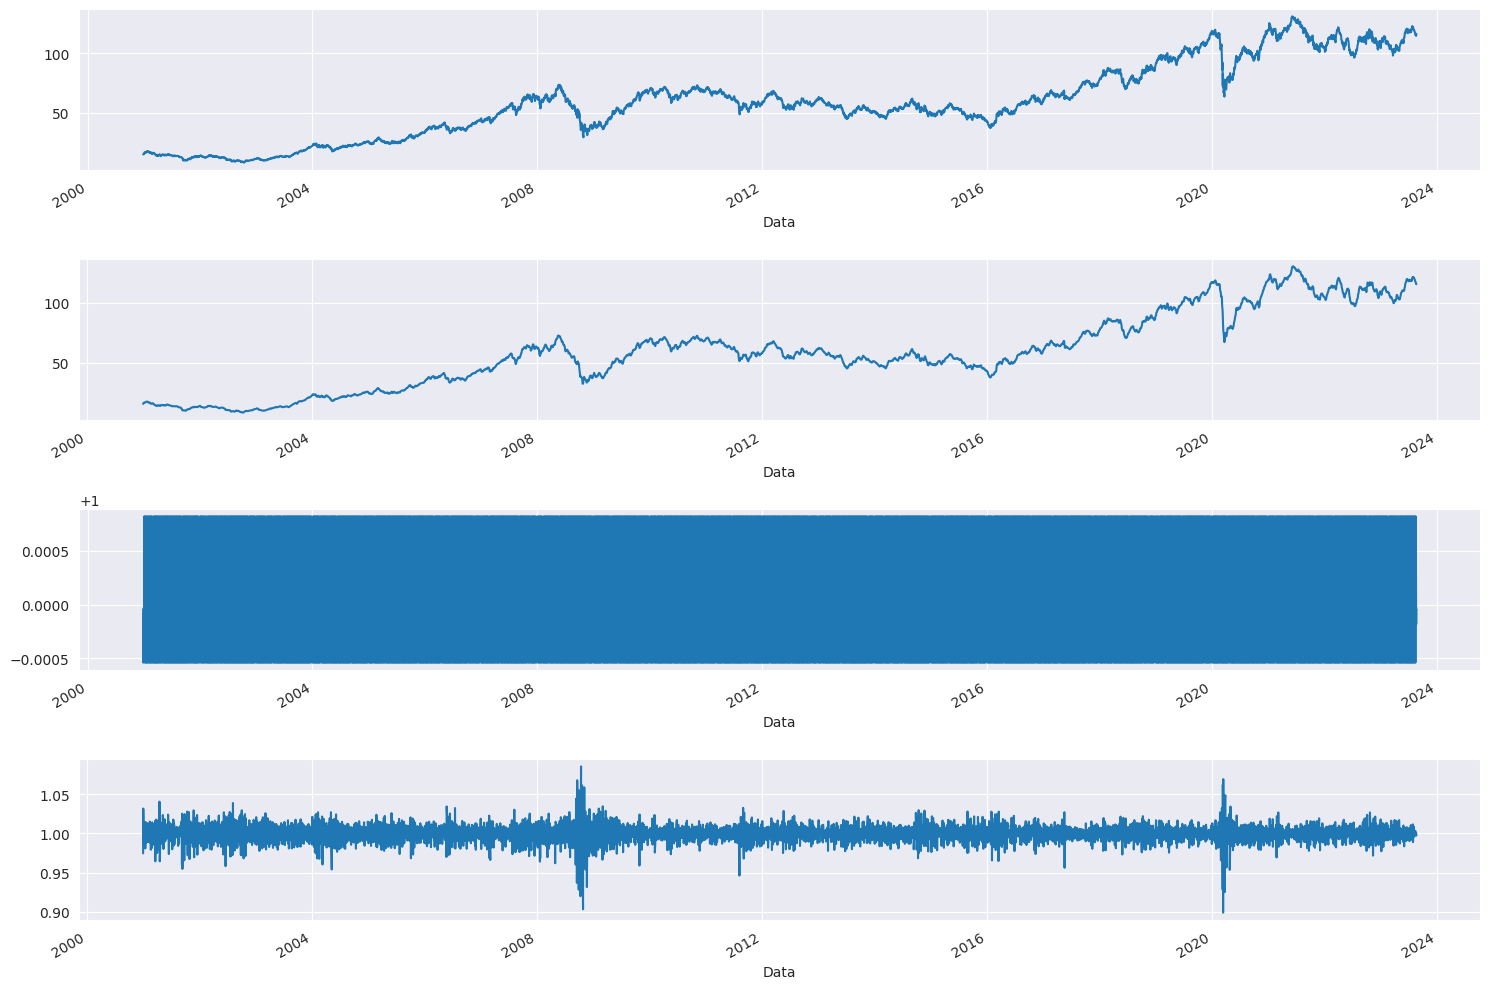

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos / ruídos

plt.tight_layout()
plt.show()

Olhando o valor da média do residuo, ela fica muito próxima ao 1, sendo um indicativo de que houveram muitos ruídos nessa base

In [15]:
resultados.resid.to_frame().mean()

resid    0.999948
dtype: float64

In [16]:
X = ibovespa_diario.Último.values

result_s = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.0113062272035385
P-Value: 0.7491183101869306
Valores Críticos:
	1%: -3.4315184766153255
	5%: -2.8620563524707463
	10%: -2.567044852955301


In [17]:
result_adfuller = pd.Series(result_s[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P', 'Lags Usados','Número de observações usadas'])
result_adfuller = round(result_adfuller, 4)

for key, value in result_s[4].items():
    result_adfuller["Valores Críticos (%s)"%key] = value.round(4)
result_adfuller

Teste Estatistico Dickey Fuller      -1.0113
Valor-P                               0.7491
Lags Usados                          11.0000
Número de observações usadas       5599.0000
Valores Críticos (1%)                -3.4315
Valores Críticos (5%)                -2.8621
Valores Críticos (10%)               -2.5670
dtype: float64

Ao entender que na série temporal existem fatores que podem dar um resultado falsamente positivo, devido as chances de oscilações externas, o tratamento para obter um melhor resultado seria iniciar um processo para transforma a séries em estacionária.

No gráfico a baixo vemos o acompanhamento do período de fechamento com o a média móvel do período

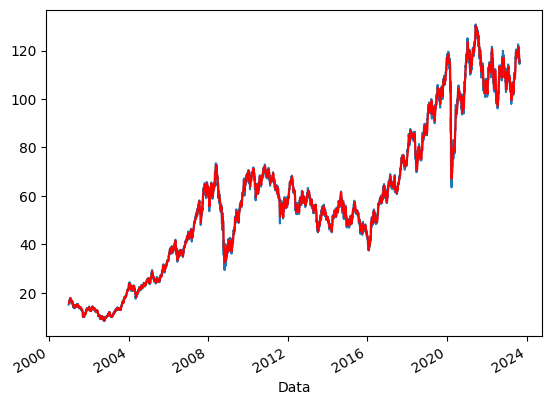

In [8]:
ma = ibovespa_diario['Último'].rolling(5).mean()
f, ax = plt.subplots()
ibovespa_diario['Último'].plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.show()

Iniciamente a primeira alteração é na conversão dos dados para valores logaritmicos. Valores não devem sofrer alteração

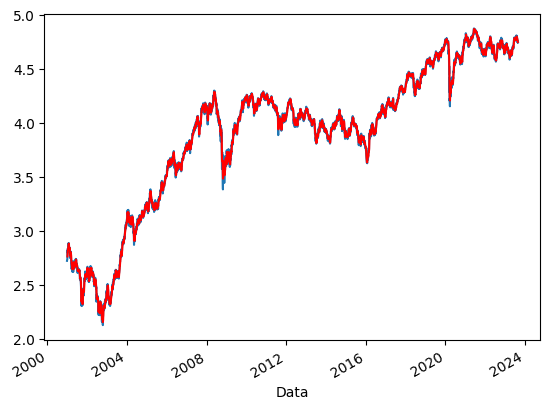

In [9]:
df_log = np.log(ibovespa_diario['Último'])
ma_log = df_log.rolling(5).mean()
f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.show()

Depois visualizamos a primeira modificação dos dados.

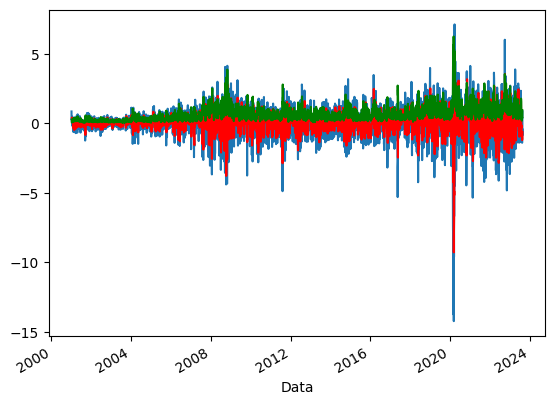

In [10]:
ma_log = ibovespa_diario['Último'].rolling(5).mean()
df_s = (ibovespa_diario['Último'] - ma_log).dropna()
ma_s = df_s.rolling(5).mean()
std  = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.show()

De acordo com os testes podemos validar alguns valores como o P-value que se mostra muito menor que zero

In [21]:
X_s = df_s.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -20.803286187010617
P-Value: 0.0
Valores Críticos:
	1%: -3.4315186854422413
	5%: -2.8620564447336996
	10%: -2.5670449020697306


Teste ADF
Teste Estatístico: -21.60653417321236
P-Value: 0.0
Valores Críticos:
	1%: -3.431523930482647
	5%: -2.862058762071348
	10%: -2.5670461356607435


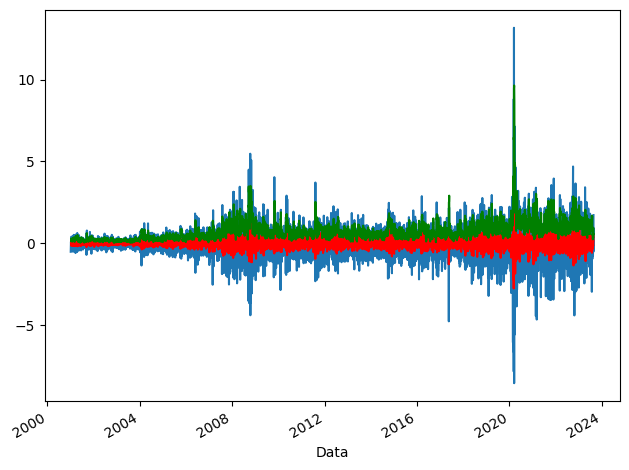

In [11]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(5).mean()
std_diff = df_diff.rolling(5).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.dropna().values

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print(f"Valores Críticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value}")

In [23]:
dados_decompose = df_diff.to_frame()
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

Ao olhar novamente para a serie transformada em estacionaria fazemos usa decomposição

In [69]:
dados_decompose = df_s.to_frame()
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

In [70]:
resultados = seasonal_decompose(dados_decompose, period=5)

Como diagnostico vemos que o tanto na tendência ela sofre a alteração, como também no residuo. Ao verificar sua média agora ela fica bem próxima do número 0, demontrando uma melhora significa em fatores que não podem ser previstos.

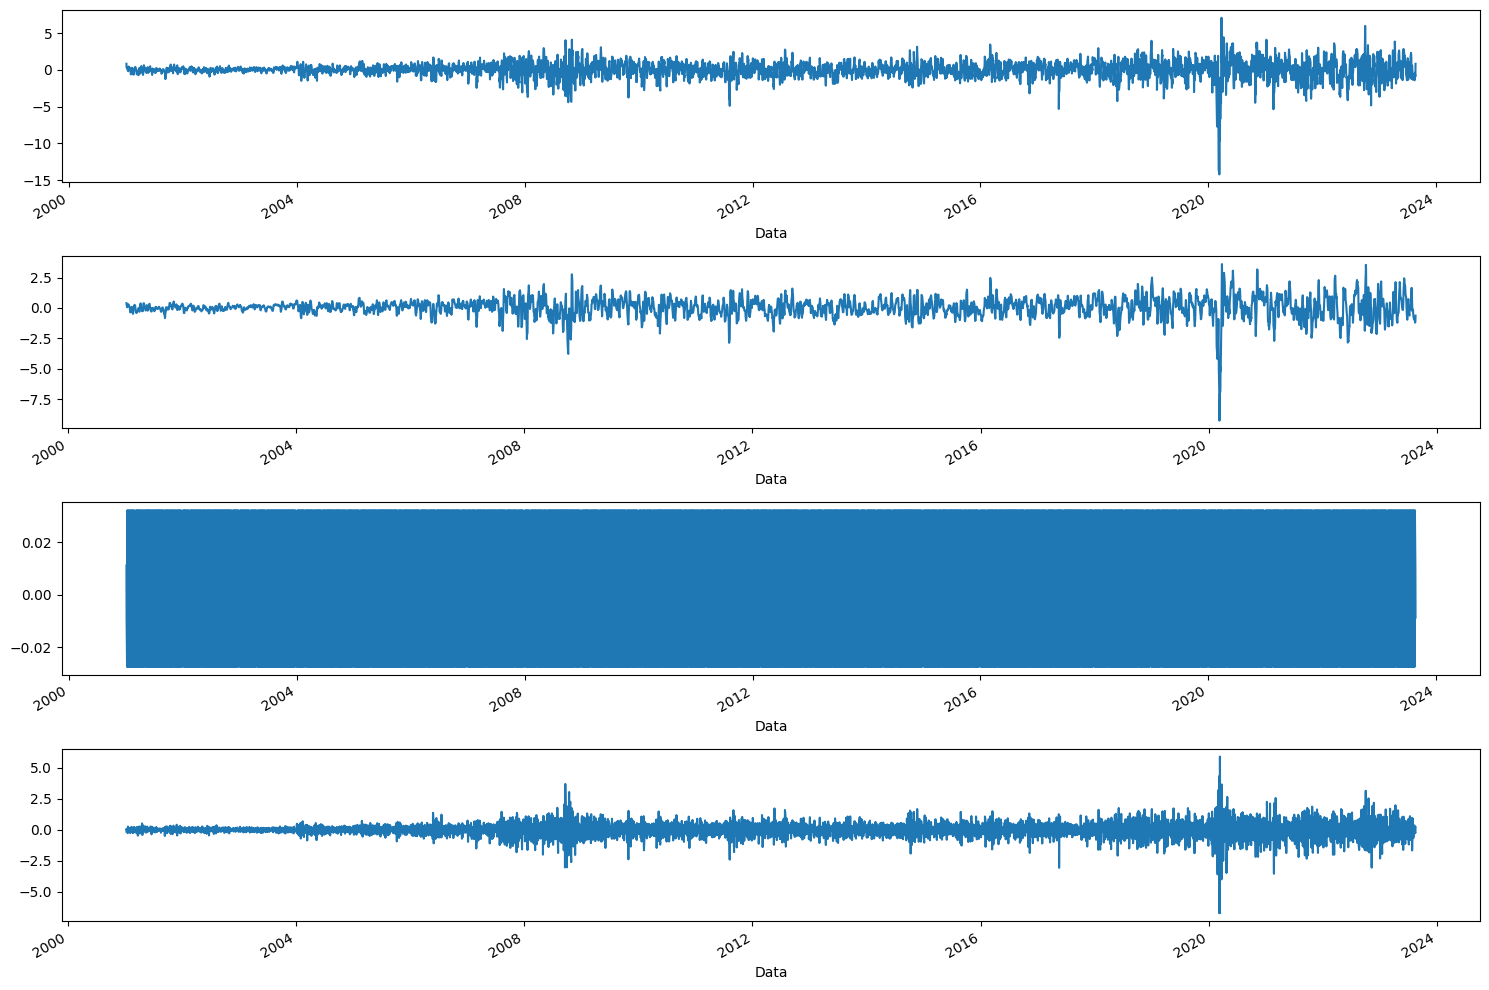

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos

plt.tight_layout()
plt.show()

In [72]:
resultados.resid.to_frame().mean()

resid   -0.000068
dtype: float64

LAG E PACF

In [77]:
lag_acf = acf(df_s.dropna(), nlags=25)
lag_pacf = pacf(df_s.dropna(), nlags=25)

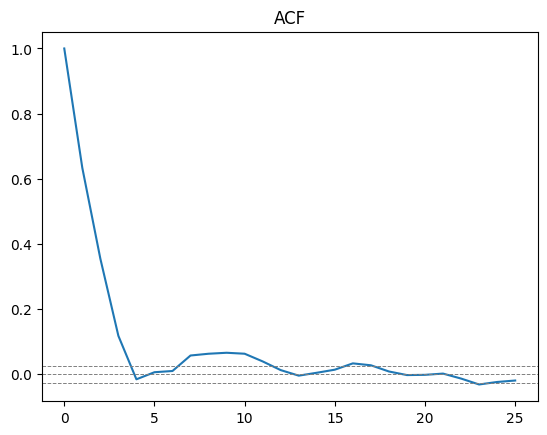

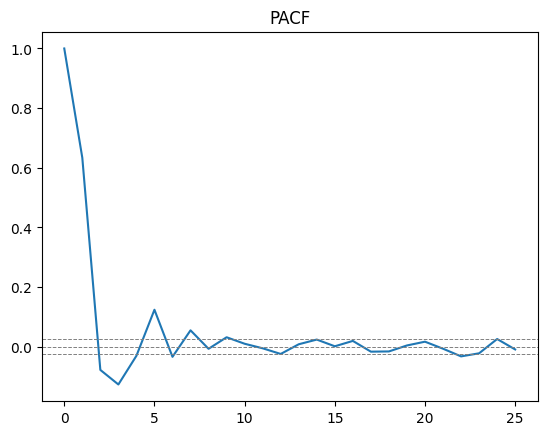

In [78]:
plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=0/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt(len(df_s) - 1)), linestyle="--", color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

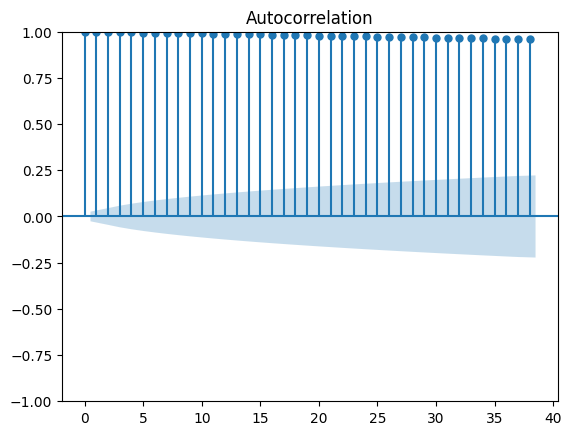

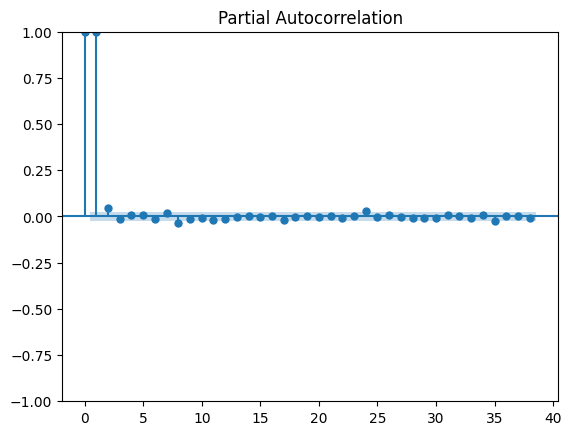

In [80]:
plot_acf(ibovespa_diario['Último'])
plot_pacf(ibovespa_diario['Último'])
plt.show()

In [12]:
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [ ]:
df_x = df_diff.to_frame().reset_index().rename(columns={"Data": "ds", "Último": "y"})
df_x['unique_id']  = 'Ibovespa'
treino = df_x.loc[(df_x['ds'].dt.year <=2023) & (df_x['ds'].dt.month < 8)]
treino = treino.dropna()
valid = df_x.loc[(df_x['ds'].dt.year >= 2023) & (df_x['ds'].dt.month >= 8)]
h = valid['ds'].nunique()

In [ ]:
valid

,ds,y,unique_id
638,2023-08-01,-0.5430,Ibovespa
639,2023-08-02,-0.0488,Ibovespa
640,2023-08-03,-0.3922,Ibovespa
641,2023-08-04,-0.9422,Ibovespa
642,2023-08-07,0.3846,Ibovespa


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS

In [ ]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=12)], freq='B', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[5])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfs = forecast_dfs.dropna()
wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

WMAPE: 105.70%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


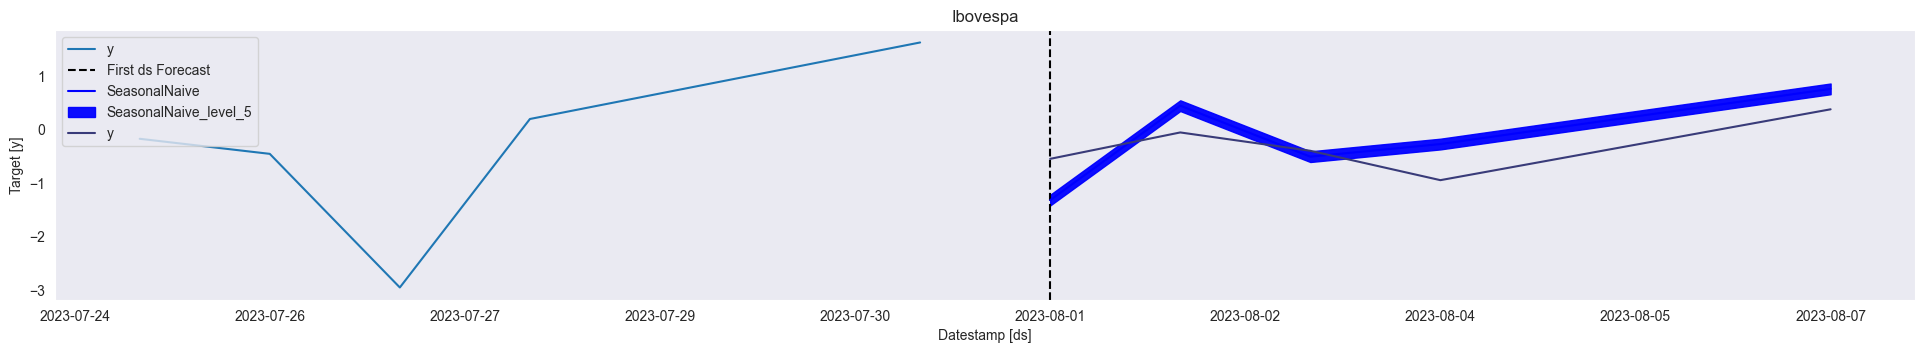

In [ ]:
model_s.plot(treino, forecast_dfs, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [ ]:
forecast_dfs

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-5,SeasonalNaive-hi-5,y
0,Ibovespa,2023-08-01,-1.3156,-1.415724,-1.215476,-0.5430
1,Ibovespa,2023-08-02,0.4526,0.352476,0.552724,-0.0488
2,Ibovespa,2023-08-03,-0.5022,-0.602324,-0.402076,-0.3922
3,Ibovespa,2023-08-04,-0.2662,-0.366324,-0.166076,-0.9422
4,Ibovespa,2023-08-07,0.7672,0.667076,0.867324,0.3846


In [ ]:
model_a = StatsForecast(models=[AutoARIMA(season_length=3)], freq='C',n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[5])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.dropna()
wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

WMAPE: 82.50%


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


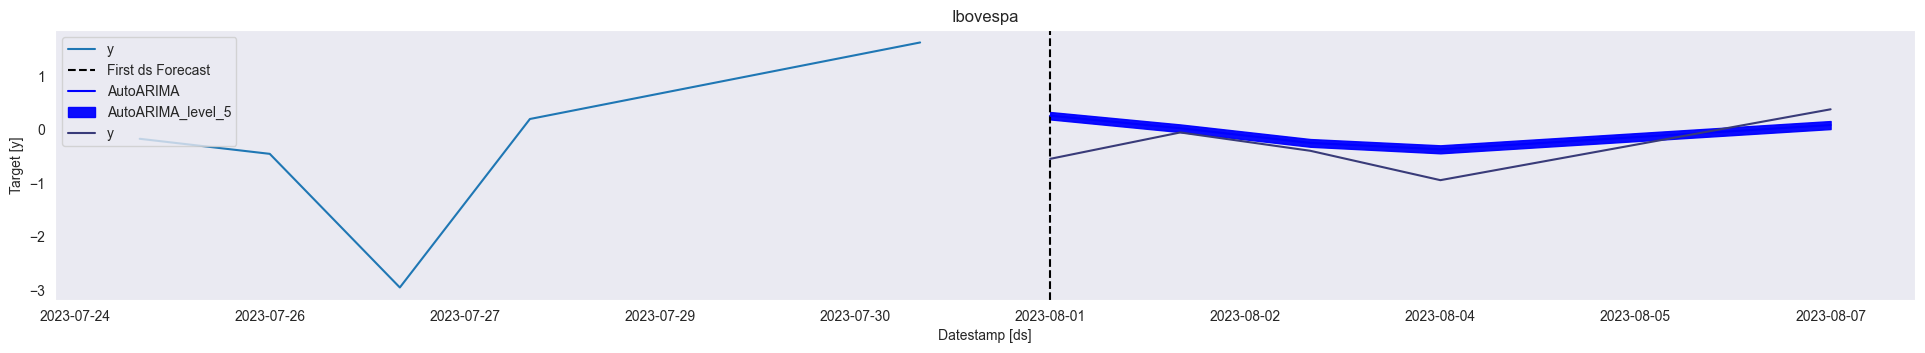

In [ ]:
model_a.plot(treino, forecast_dfa, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [ ]:
forecast_dfa

,unique_id,ds,AutoARIMA,AutoARIMA-lo-5,AutoARIMA-hi-5,y
0,Ibovespa,2023-08-01,0.002554,0.001939,0.003170,-0.004466
1,Ibovespa,2023-08-02,-0.000053,-0.000680,0.000574,-0.000418
2,Ibovespa,2023-08-03,-0.001879,-0.002522,-0.001237,-0.003252
3,Ibovespa,2023-08-04,-0.002983,-0.003650,-0.002317,-0.007847
4,Ibovespa,2023-08-07,0.000693,0.000025,0.001361,0.003177


In [ ]:
m = Prophet()
m.fit(treino)

12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=5)
future.tail()

,ds
428,2023-08-01
429,2023-08-02
430,2023-08-03
431,2023-08-04
432,2023-08-05


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
428,2023-08-01,-0.382660,-1.953772,1.091503
429,2023-08-02,-0.276966,-1.759934,1.256854
430,2023-08-03,-0.554580,-2.091053,1.009024
431,2023-08-04,-0.845553,-2.350647,0.662900
432,2023-08-05,-1.978890,-3.479809,-0.507954


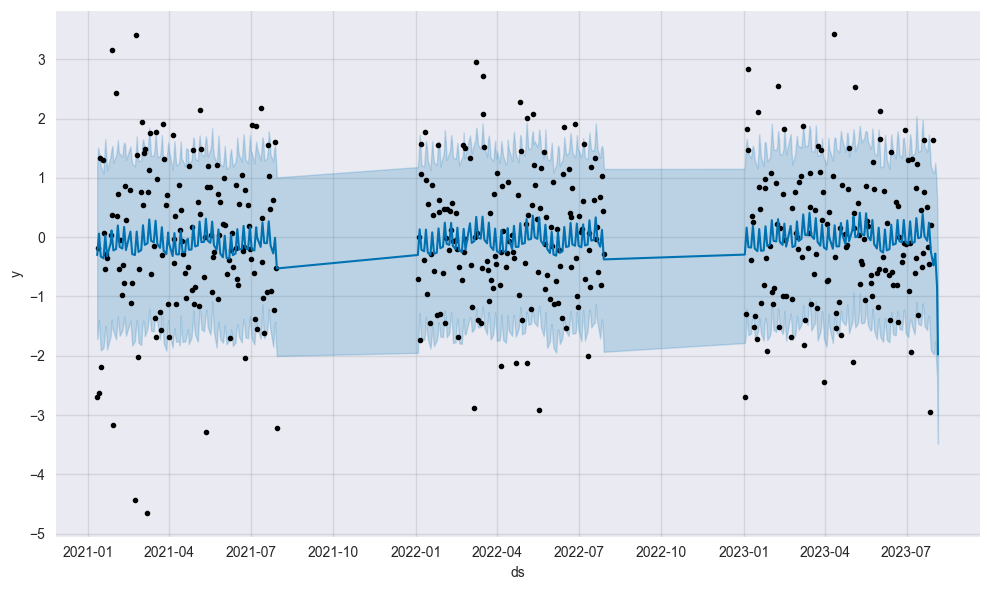

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2021-03-11,114.984,112.782,115.127,112.776,"12,09M","1,96%"
2021-03-10,112.776,111.331,112.928,109.999,"12,51M","1,30%"
2021-03-09,111.331,110.611,112.525,109.343,"12,14M","0,65%"
2021-03-08,110.612,115.202,115.202,110.268,"13,70M","-3,98%"
2021-03-05,115.202,112.690,115.504,112.504,"13,25M","2,23%"
...,...,...,...,...,...,...
2001-01-04,16.675,16.597,16.933,16.587,"331,23M","0,46%"
2001-01-03,16.599,15.425,16.599,15.251,"381,20M","7,61%"
2001-01-02,15.425,15.242,15.621,15.174,"230,63M","1,09%"


In [ ]:
df_prophet =  df_s.to_frame().reset_index()
df_prophet = df_prophet.rename(columns={"Data":"ds", "Último": "y"})
forecast = forecast.merge(df_prophet[["ds", "y"]], on=['ds'], how='left')
forecast = forecast.dropna()

In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
427,2023-07-31,-0.888685,-1.970682,1.083560,-0.888685,-0.888685,0.412411,0.412411,0.412411,0.176655,0.176655,0.176655,0.235756,0.235756,0.235756,0.0,0.0,0.0,-0.476273,0.6054
428,2023-08-01,-0.888534,-1.953772,1.091503,-0.888534,-0.888534,0.505875,0.505875,0.505875,0.359351,0.359351,0.359351,0.146524,0.146524,0.146524,0.0,0.0,0.0,-0.382660,0.0624
429,2023-08-02,-0.888384,-1.759934,1.256854,-0.888384,-0.888384,0.611418,0.611418,0.611418,0.559728,0.559728,0.559728,0.051690,0.051690,0.051690,0.0,0.0,0.0,-0.276966,0.0136
430,2023-08-03,-0.888234,-2.091053,1.009024,-0.888234,-0.888234,0.333654,0.333654,0.333654,0.381399,0.381399,0.381399,-0.047745,-0.047745,-0.047745,0.0,0.0,0.0,-0.554580,-0.3786
431,2023-08-04,-0.888084,-2.350647,0.662900,-0.888084,-0.888084,0.042531,0.042531,0.042531,0.193183,0.193183,0.193183,-0.150652,-0.150652,-0.150652,0.0,0.0,0.0,-0.845553,-1.3208


In [ ]:
print(f"WMAPE: {wmape(forecast[['y']].tail().values, forecast[['yhat']].tail().values):.2%}")

WMAPE: 103.68%


In [ ]:
treino

,ds,y,unique_id
0,2021-01-08,0.033678,Ibovespa
1,2021-01-11,0.011734,Ibovespa
2,2021-01-12,0.010147,Ibovespa
3,2021-01-13,-0.011349,Ibovespa
4,2021-01-14,-0.000515,Ibovespa
...,...,...,...
633,2023-07-25,0.018033,Ibovespa
634,2023-07-26,0.014203,Ibovespa
635,2023-07-27,-0.010193,Ibovespa
636,2023-07-28,-0.008503,Ibovespa


In [ ]:
treino

,ds,y,unique_id
0,2021-01-08,NaN,Ibovespa
1,2021-01-11,-0.021944,Ibovespa
2,2021-01-12,-0.001587,Ibovespa
3,2021-01-13,-0.021495,Ibovespa
4,2021-01-14,0.010834,Ibovespa
...,...,...,...
633,2023-07-25,-0.001476,Ibovespa
634,2023-07-26,-0.003830,Ibovespa
635,2023-07-27,-0.024396,Ibovespa
636,2023-07-28,0.001690,Ibovespa


In [ ]:
#autoETS

# model_a = StatsForecast(models=[AutoETS(season_length=3, model='ZMZ')], freq='B',n_jobs=-1)
# model_a.fit(treino)

# forecast_dfa = model_a.predict(h=h, level=[5])
# forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
# forecast_dfa = forecast_dfa.dropna()
# wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values)
# print(f"WMAPE: {wmape4:.2%}")

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\ets.py:1039: RuntimeWarning: overflow encountered in square
  sigma2 = np.sum(e**2) / (ny - np_ - 1)


Exception: no model able to be fitted

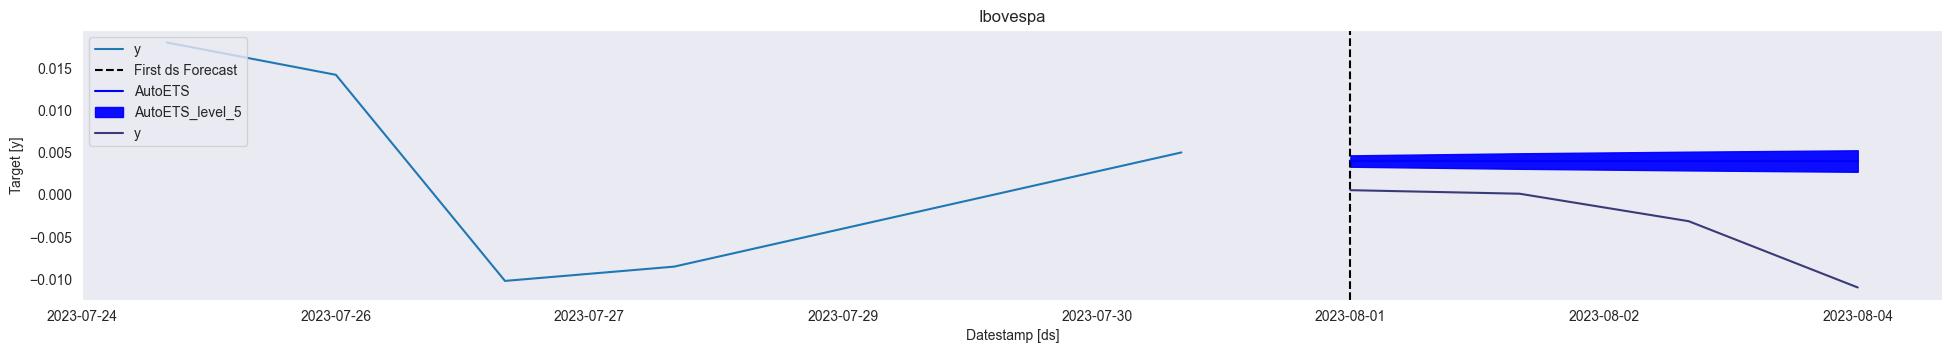

In [ ]:
model_a.plot(treino, forecast_dfa, level=[5], unique_ids=['Ibovespa'], engine="matplotlib", max_insample_length=5)

In [ ]:
a = wmape(forecast_dfa['y'].values[0:4], forecast_dfa['AutoETS'].values[0:4])

In [ ]:
print(f"WMAPE: {a:.2%}")

WMAPE: 199.07%


In [ ]:
forecast_dfa

,unique_id,ds,AutoETS,AutoETS-lo-5,AutoETS-hi-5,y
0,Ibovespa,2023-08-01,0.003997,0.003323,0.004671,0.000548
1,Ibovespa,2023-08-02,0.003997,0.003079,0.004915,0.000130
2,Ibovespa,2023-08-03,0.003997,0.002888,0.005106,-0.003122
3,Ibovespa,2023-08-04,0.003997,0.002725,0.005269,-0.010969


# Modificação gabriel

In [ ]:
# Executar caso for a primeira vez que iniciou o notebook
!pip install statsforecast

In [64]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, HoltWinters, AutoETS,AutoARIMA, ARIMA,

In [16]:
## Validação do dataset
df_s.to_frame().tail(10)

,Último
Data,
2023-08-09,-0.9856
2023-08-10,-0.5974
2023-08-11,-0.5938
2023-08-14,-1.3348
2023-08-15,-1.3900
2023-08-16,-1.4056
2023-08-17,-1.3420
2023-08-18,-0.3838
2023-08-21,-0.8876


Com os dados já modificados, é feita criação dos valores de treino na formatação solicitada dos modelos

In [17]:
# Tratamento treino
df_treino_s = df_s.to_frame()
df_treino_s['unique_id'] = 'Ibovespa'
df_treino_s.reset_index(inplace=True)
df_treino_s.rename({'Data':'ds','Último':'y'}, axis=1, inplace=True)
df_treino_s.head()

,ds,y,unique_id
0,2001-01-04,0.8462,Ibovespa
1,2001-01-05,0.3364,Ibovespa
2,2001-01-08,0.2278,Ibovespa
3,2001-01-09,0.3316,Ibovespa
4,2001-01-10,0.2106,Ibovespa


O filtro de tempo que é utilizado para fazer o treinamento do modelo corresponde ao período de 27-12-2000 até 14-08-2023  usar para checagem de predição usamos os 5 próximos dias.

In [18]:
# Filtro validação
# Pegando um periodo de 5 dias

df_valid_s = df_treino_s.loc[(df_treino_s['ds'] >= '2023-08-14') & (df_treino_s['ds'] < '2023-08-21')]
df_treino_s = df_treino_s.loc[df_treino_s['ds'] < '2023-08-14']

In [19]:
h = df_valid_s.shape[0]
h

5

In [20]:
df_valid_s.head()

,ds,y,unique_id
5600,2023-08-14,-1.3348,Ibovespa
5601,2023-08-15,-1.3900,Ibovespa
5602,2023-08-16,-1.4056,Ibovespa
5603,2023-08-17,-1.3420,Ibovespa
5604,2023-08-18,-0.3838,Ibovespa


Um dos modelos testados é o AutoETS, que é uns do modelos que usa os melhores parametros para tentar encontrar os melhores resultados. Onde sua acurária em cima do modelo se torna 44%  

In [83]:
model_auto_ets = StatsForecast(models=[AutoETS(season_length=5, model='AAN')], freq='B', n_jobs=-1)
model_auto_ets.fit(df_treino_s)

forecast_df_auto_ets = model_auto_ets.predict(h=h, level=[90])
forecast_df_auto_ets = forecast_df_auto_ets.reset_index().merge(df_valid_s, on=['ds'], how='left')

wmape_auto_ets = wmape(forecast_df_auto_ets['y'].values, forecast_df_auto_ets['AutoETS'].values)

print(f'{(1 - wmape_auto_ets):.2%}')

44.01%


In [26]:
model_auto_mstl = StatsForecast(models=[AutoARIMA(season_length=5)], freq='B', n_jobs=-1)
model_auto_mstl.fit(df_treino_s)

forecast_df_mstl = model_auto_mstl.predict(h=h, level=[90])
forecast_df_mstl = forecast_df_mstl.reset_index().merge(df_valid_s, on=['ds'], how='left')

# wmape_auto_MSTL = wmape(forecast_df_mstl['y'].values, forecast_df_mstl['AutoETS'].values)

# print(f'{wmape_auto_ets:.2%}')

In [63]:
forecast_df_mstl

,unique_id_x,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y,unique_id_y
0,Ibovespa,2023-08-14,-0.252615,-1.604440,1.099210,-1.3348,Ibovespa
1,Ibovespa,2023-08-15,-0.119986,-1.755226,1.515253,-1.3900,Ibovespa
2,Ibovespa,2023-08-16,-0.084935,-1.838998,1.669129,-1.4056,Ibovespa
3,Ibovespa,2023-08-17,-0.013046,-1.793230,1.767137,-1.3420,Ibovespa
4,Ibovespa,2023-08-18,-0.059301,-1.839616,1.721014,-0.3838,Ibovespa


In [28]:
wmape_auto_MSTL = wmape(forecast_df_mstl['y'].values, forecast_df_mstl['AutoARIMA'].values)

print(f'{wmape_auto_ets:.2%}')

56.02%


O segundo modelo que houve uma melhora na performance foi o HoltWinters, modelo utilizado para olhar para as médias do passado ao tentar gerar o resultado do futuro

In [94]:
model_hold_winters = StatsForecast(models=[HoltWinters(season_length=5)], freq='B', n_jobs=-1)
model_hold_winters.fit(df_treino_s)

forecast_df_holt = model_hold_winters.predict(h=h, level=[90])
forecast_df_holt = forecast_df_holt.reset_index().merge(df_valid_s, on=['ds'], how='left')

wmape_auto_holt = wmape(forecast_df_holt['y'].values, forecast_df_holt['HoltWinters'].values)

print(f'{(1 - wmape_auto_holt):.2%}')

46.48%


In [104]:
forecast_df_holt.rename({'unique_id_x': 'unique_id'},axis=1, inplace=True)

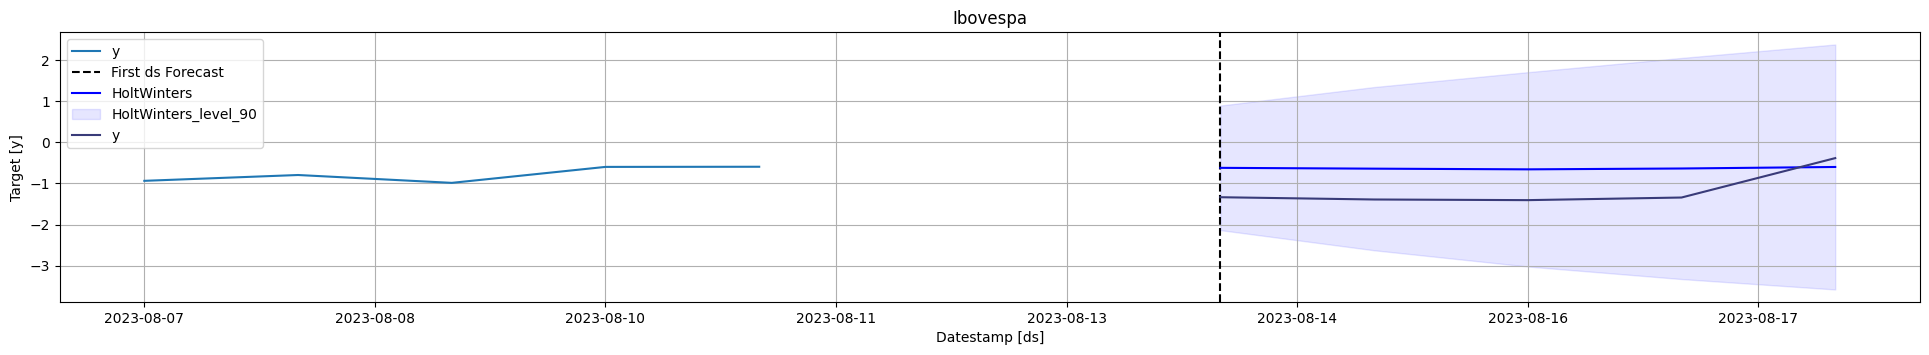

In [105]:
model_hold_winters.plot(df_treino_s, forecast_df_holt, unique_ids=['Ibovespa'], level=[90], max_insample_length=5)

In [68]:
model_window_avg = StatsForecast(models=[SimpleExponentialSmoothing(alpha=5.0)], freq='B', n_jobs=-1)
model_window_avg.fit(df_treino_s)

forecast_df_window = model_window_avg.predict(h=h, level=[90])
forecast_df_window = forecast_df_window.reset_index().merge(df_valid_s, on=['ds'], how='left')

wmape_auto_holt = wmape(forecast_df_window['y'].values, forecast_df_window['SimpleExponentialSmoothing'].values)

print(f'{wmape_auto_holt:.2%}')

Exception: ignored